## Model following KK10

NB: Vmin has an impact on L. See how I handle this. One idea would be to use storm_speed as an ersatz for Vmin.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# PATHS = {
#     'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#     'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
#     'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
# }

In [3]:
PRMS = {
    'vmin':  4,                           # minimum wind speed for Holland profile fitting [m/s]
    'rs':    np.linspace(10, 5e5, 50000), # ref. grid [m] - take a lot of points to compute vorticity properly
    'dt':    6 * 3600,                    # timestep [s]
    'dilat': True,
}

In [4]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def charac_length(V):
    '''Given a wind profile object V, returns its characteristic length L'''
    rel_vort = vorticity(V.rad, V.ws)
    abs_vort = coriolis(V.lat)
    q        = (V.rad * V.ws ** 2) / (rel_vort + abs_vort)
    return V.rad[np.nanargmax(q)]

def get_scales(V, show=False):
    # Fit Holland
    vmx, rmx, B = fit_h80(V)
    # Compute L on Vh relative (vmin = 0)
    Vh_rel = xr.Dataset(
        data_vars={
            'ws': ('rad', h80(V.rad, vmx, rmx, B, V.lat, 0).data),
            'lat': V.lat.data,
            'time': V.time.data,
        },
        coords={
            'rad': V.rad.data
        }
    )
    # Compute scales
    L      = charac_length(Vh_rel) # Vmin must be 0
    U_star = coriolis(Vh_rel.lat) * rmx
    
    if show:
        print('B  = {:.1f}'.format(B))
        print('L  = {:.0f} km'.format(L / 1000))
        print('U* =  {:.1f} m/s'.format(U_star))
        print('T  = {:.1f} h'.format(L / U_star / 3600))        
    return L, U_star
    
def nb_of_timesteps(L, U_star, delta_t, show=False):
    nt = delta_t / (L / U_star)
    if show:
        print('nb of t-stps: {:.2f}'.format(nt))
    return nt

def non_dimensional(V, L):
    V_nd = xr.DataArray(
        data=V.ws / (coriolis(V.lat) * L),
        coords={'rad': V.rad / L}
    )
    return V_nd

# def dimensional(ws, V, L):
#     V_nd = xr.DataArray(
#         data=ws * coriolis(V.lat) * L,
#         coords={'rad': V.rad}
#     )
#     return V_nd

def h80(r, vm, rm, B, lat, vmin=PRMS['vmin']):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_h80(V):
    '''Given an xr.Dataset V of wind speed 'ws' with 'rad' as dim & coord (m) and 'lat' as second variable,
    returns the parameters of fitted Holland 1980 profile.
    CAVEAT: coordinate 'rad' must be > 0, else the residuals are not finite for r = 0.
    '''
    popt, pcov = curve_fit(
        f=lambda r, vm, rm, B: h80(r, vm, rm, B, V.lat, vmin=PRMS['vmin']),
        xdata=V.rad,
        ydata=V['ws'],
        p0=[V['ws'].max(), V.rad[V['ws'].argmax()], 1.5],
        bounds=[
            (V['ws'].max() * 0.5, V.rad[V['ws'].argmax()] * 0.5, 0.5,),
            (V['ws'].max() * 1.5, V.rad[V['ws'].argmax()] * 1.5, 5,)
        ]
    )
    return popt # Vmax, Rmax, B

# def fit_h80(V):
#     '''Given an xr.Dataset V of wind speed 'ws' with 'rad' as dim & coord (m) and 'lat' as second variable,
#     returns the parameters of fitted Holland 1980 profile.
#     CAVEAT: coordinate 'rad' must be > 0, else the residuals are not finite for r = 0.
#     '''
#     popt, pcov = curve_fit(
#         f=lambda r, vm, rm, B, vmin: h80(r, vm, rm, B, V.lat, vmin),
#         xdata=V.rad,
#         ydata=V['ws'],
#         p0=[V['ws'].max(), V.rad[V['ws'].argmax()], 1.5, V['ws'].min()],
#         bounds=[
#             (V['ws'].max() * 0.5, V.rad[V['ws'].argmax()] * 0.5, 0.5, V['ws'].min() * 0.5),
#             (V['ws'].max() * 1.5, V.rad[V['ws'].argmax()] * 1.5, 5,   V['ws'].min() * 1.5)
#         ]
#     )
#     return popt # Vmax, Rmax, B, Vmin

def v_kk11(v0, t, lbda):
    '''Given an initial wind profile v0, propagates according to KK11 and using lambda'''
    v          = np.zeros_like(v0.rad)
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def V_KK11(Vi, L, nt, lbda):
    '''Make wind profile non-dimensional, then perform v_kk11(), then go back to dimensional wind profile'''
    # Non-dimensionalization
    Vi_nd = non_dimensional(Vi, L)
    # Get Kalashnik wind
    Vk_nd = xr.DataArray(
        data=v_kk11(Vi_nd, nt, lbda),
        coords={'rad': Vi_nd.rad}
    )
    # Dimensionalize
    Vk_d  = xr.DataArray(
        data=Vk_nd * coriolis(Vi.lat) * L,
        coords={'rad': Vi.rad}
    )
    # Formatting
    Vf = xr.Dataset(
        data_vars={
            'ws':          ('rad', Vk_d.data),
            'lat':         Vi.lat.data + 5 * PRMS['dt'] * np.cos(np.pi / 4) / 110000, # assume TC goes at 5 m/s, with an angle 45° from North, and 1°N is 110 km
            # 'storm_speed': dss.storm_speed_IBT.data,
            'time':        Vi.time.data + np.timedelta64(PRMS['dt'],'s'),
        },
        coords={
            'rad': Vi.rad.data
        }
    )
    # Fill end of profile with last value (to avoid NaNs, otherwise curve_fit doesn't work)
    Vf['ws'] = Vf.ws.fillna(Vf.ws[Vf.ws.notnull()][-1])
    return Vf

# def R17(V):
#     ws_out = V.isel(rad=slice(int(V.ws.argmax()), None)).ws
#     return ws_out.where(ws_out < 17.5, drop=True).isel(rad=0).rad

# def dilat_factor(V, alpha=(1 / 35)):
#     r17  = R17(V)
#     fcor = coriolis(V.lat)
#     return alpha * (fcor * r17)

# def dilat(V, alpha):
#     V_dilat        = V.copy(deep=True)
#     V_dilat['rad'] = V_dilat['rad'] * (1 + dilat_factor(V_dilat, alpha)) 
#     V_dilat        = V_dilat.interp({'rad': PRMS['rs']})
#     # Fill beginning of profile with first value (to avoid NaNs, otherwise curve_fit doesn't work)
#     V_dilat['ws']  = V_dilat.ws.fillna(V_dilat.ws[V_dilat.ws.notnull()][0])
#     return V_dilat

def dilat_v2(V, alpha):
    V_dilat        = V.copy(deep=True)
    V_dilat['rad'] = V_dilat['rad'] * (1 + alpha) 
    V_dilat        = V_dilat.interp({'rad': PRMS['rs']})
    # Fill beginning of profile with first value (to avoid NaNs, otherwise curve_fit doesn't work)
    V_dilat['ws']  = V_dilat.ws.fillna(V_dilat.ws[V_dilat.ws.notnull()][0])
    return V_dilat

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


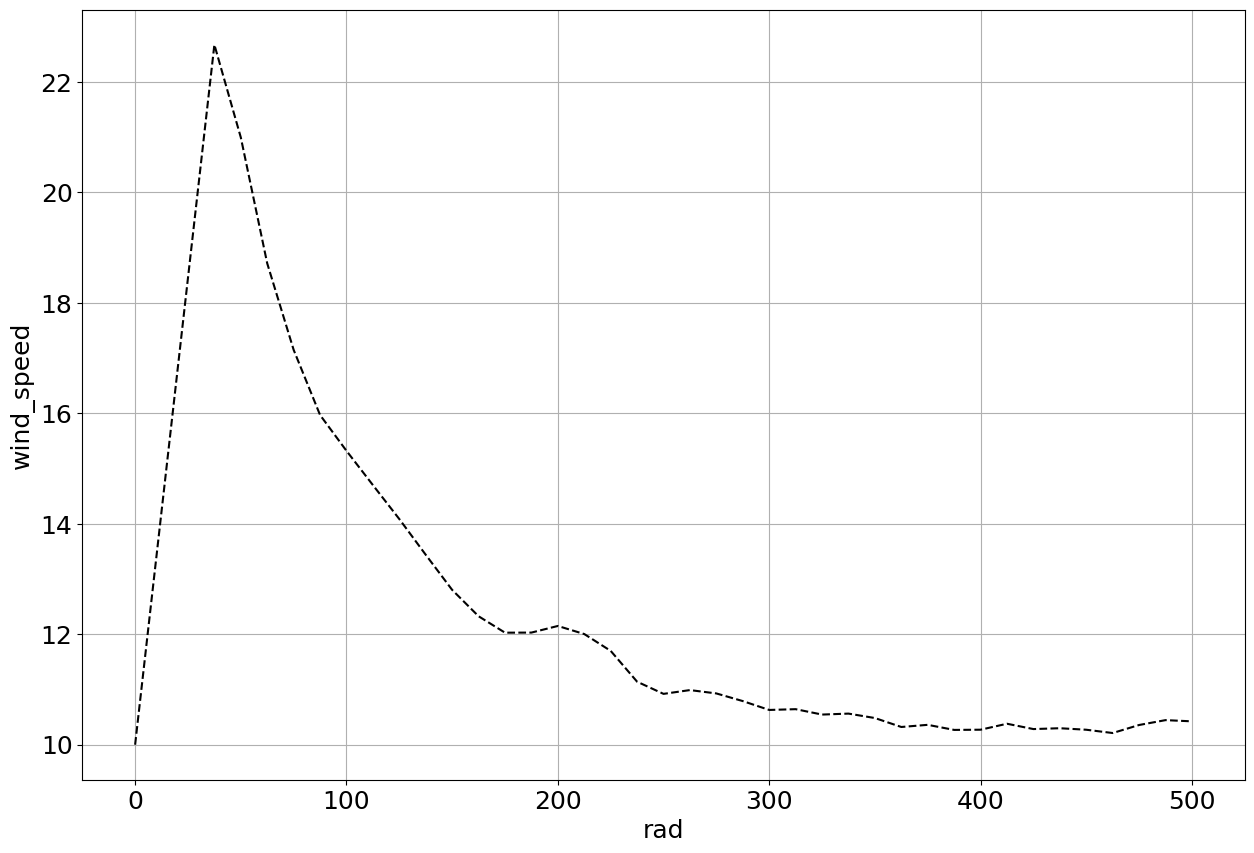

In [5]:
p   = '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/POL_ascat_20201001_044800_metopb_41705_srv_o_125_ovw.nc'
dss = xr.open_dataset(p)

# Custom initialization
def affine(vmax, vmin, rmax, r):
    return ((vmax - vmin) / (rmax - 0)) * r + vmin

V_ini        = dss.wind_speed.mean(dim='theta', skipna=True)
V_ini[0]     = 10
V_ini[1]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=1 * 12.5)
V_ini[2]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=2 * 12.5)
V_ini.plot(c='k', linestyle='--', label='custom total');plt.grid()
V_ini['rad'] = V_ini.rad * 1000
V_ini        = V_ini.interp({'rad': PRMS['rs']})

# Create the structure
Vi = xr.Dataset(
    data_vars={
        'ws':          ('rad', V_ini.data),
        'lat':         dss.lat_IBT.data,
        # 'storm_speed': dss.storm_speed_IBT.data,
        'time':        dss.acquisition_time.data,
    },
    coords={
        'rad': PRMS['rs']
    }
)
# # Create the structure
# Vi = xr.Dataset(
#     data_vars={
#         'ws':          ('rad', h80(PRMS['rs'], 13, 37000, 1.9, dss.lat_IBT.data, vmin=10).data),
#         'lat':         dss.lat_IBT.data,
#         # 'storm_speed': dss.storm_speed_IBT.data,
#         'time':        dss.acquisition_time.data,
#     },
#     coords={
#         'rad': PRMS['rs']
#     }
# )

In [6]:
### MODEL
def MODEL(V, lbda, alpha, show=False):
    L, U_star = get_scales(V, show)
    nt        = nb_of_timesteps(L, U_star, PRMS['dt'], show)
    # Apply KK11 model
    Vf = V_KK11(V, L, nt, lbda)
    # Dilatation
    Vf = dilat_v2(Vf, alpha)
    return Vf

[0, 0, 0, 0, 0, 0, 0, 0.3442231592053814, 0.3679900360969936, 0.3903123748998999, 0.41142536787773953, 0.43150656619183286, 0.45069390943299864]
B  = 0.6
L  = 188 km
U* =  1.3 m/s
T  = 40.6 h
nb of t-stps: 0.15


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.6
L  = 169 km
U* =  1.2 m/s
T  = 40.3 h
nb of t-stps: 0.15


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.7
L  = 152 km
U* =  1.0 m/s
T  = 40.6 h
nb of t-stps: 0.15


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.7
L  = 139 km
U* =  0.9 m/s
T  = 41.8 h
nb of t-stps: 0.14


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.8
L  = 127 km
U* =  0.8 m/s
T  = 42.8 h
nb of t-stps: 0.14


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.9
L  = 115 km
U* =  0.7 m/s
T  = 42.7 h
nb of t-stps: 0.14


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.9
L  = 103 km
U* =  0.7 m/s
T  = 41.9 h
nb of t-stps: 0.14


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 1.0
L  = 91 km
U* =  0.6 m/s
T  = 40.5 h
nb of t-stps: 0.15


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 1.0
L  = 92 km
U* =  0.8 m/s
T  = 32.8 h
nb of t-stps: 0.18


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 1.0
L  = 97 km
U* =  1.0 m/s
T  = 28.1 h
nb of t-stps: 0.21


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 1.0
L  = 105 km
U* =  1.2 m/s
T  = 24.9 h
nb of t-stps: 0.24


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.9
L  = 116 km
U* =  1.4 m/s
T  = 22.4 h
nb of t-stps: 0.27


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


B  = 0.9
L  = 130 km
U* =  1.8 m/s
T  = 20.0 h
nb of t-stps: 0.30


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


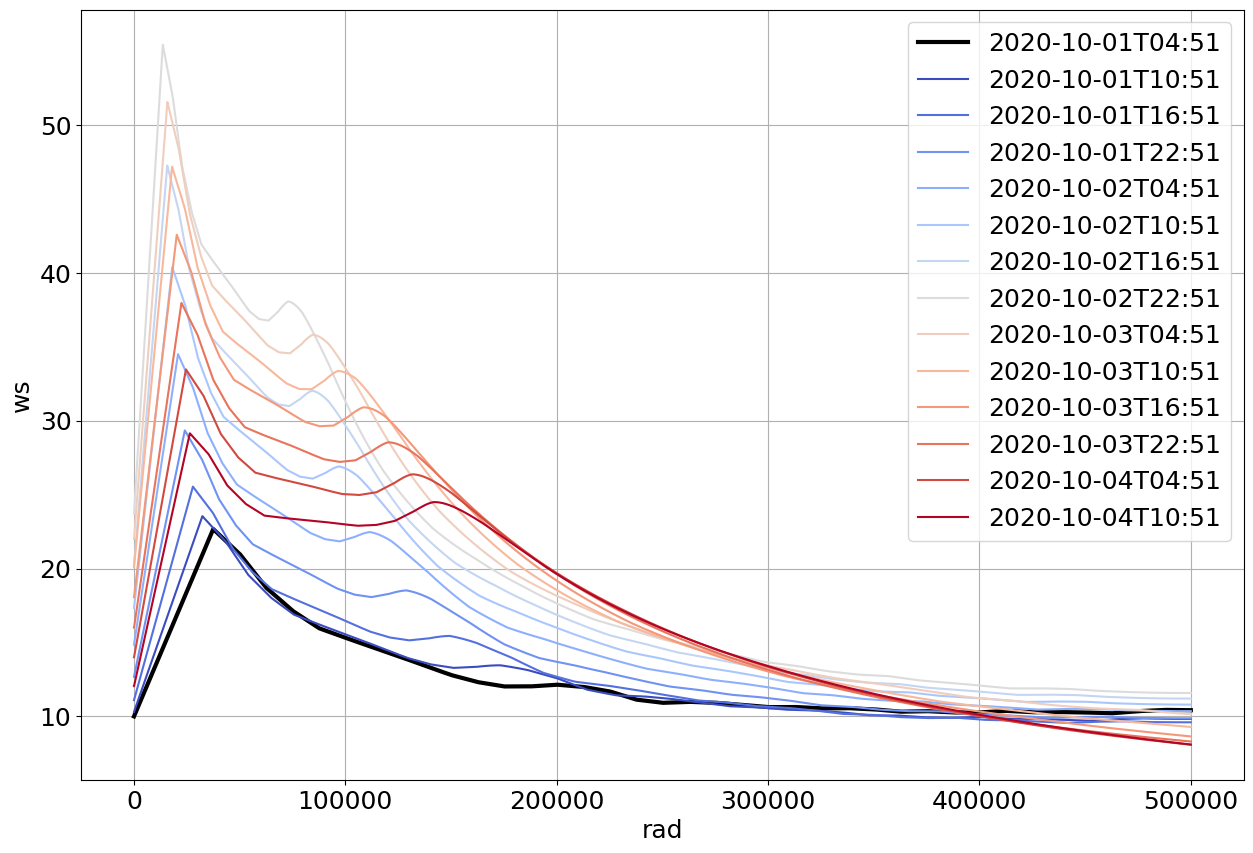

In [7]:
### EXECUTE MODEL
# lbds  = [0.3, 0.2, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5]
lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
alphas = list(np.sqrt(np.linspace(0, len(lbds), len(lbds))) / 8)
alphas[0] = alphas[1] = alphas[2] = alphas[3] = alphas[4] = alphas[5] = alphas[6] = 0
print(alphas)

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
Vi['ws'].plot(label='{}'.format(np.datetime_as_string(Vi.time, unit='m')), c='k', linewidth=3)
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V = MODEL(Vi, l, a, show=True)
    else:
        V = MODEL(V, l, a, show=True)
        
    # Plot
    V['ws'].plot(label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    
plt.grid()
plt.legend()